# Setup

In [30]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [31]:
!apt -qqq install graphviz

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [32]:
PROMOTIONAL = "PROMOTIONAL"  # sacar un promocional en un 50/50 (ganar)
PERMANENT = "PERMANENT"  # sacar un permanente en un 50/50 (perder)
GUARANTEED = "GUARANTEED"  # sacar un promocional en un asegurado (ni ganar ni perder)

# Clase grafo

Para guardar el árbol de probabilidades

In [33]:
x = {}

x[5] = 3

In [34]:
class Graph:
    def __init__(self, max_nodes):

        # La matriz de adyacencia se representa como un diccionario para ahorrar memoria
        # con los espacios en los que no hay nodos
        self._matrix = {} 

        self._max_nodes = max_nodes
        self._node_count = 0 
        self._node_names = {}
        self._node_colors = {}
        self._node_values = {}

    def _set_matrix_value(self, y, x, v):
        """
        Establece el valor de la matriz en la posición (y, x).
        """
        # Conversión de coordenadas 2D a 1D
        self._matrix[y * self._max_nodes + x] = v

    def _get_matrix_value(self, y, x):
        """
        Obtiene el valor de la matriz en la posición (y, x).
        """
        # Conversión de coordenadas 2D a 1D
        return self._matrix.get(y * self._max_nodes + x, None)

    def create_node(self, name=None, value=None, color="white"):
        """
        Crea un nuevo nodo en el grafo y lo agrega a la matriz de adyacencia.
        Devuelve el índice del nodo creado.
        """

        if self._node_count >= self._max_nodes:
            raise ValueError("No se pueden agregar más nodos al grafo.")

        index = self._node_count
        self._node_count += 1

        if name is None:
            name = "node" + str(index)

        self._node_names[index] = name
        self._node_colors[index] = color
        self._node_values[index] = value
        return index
    
    def add_edge(self, source, target, weight=1):
        """
        Agrega una arista al grafo.
        """

        self._set_matrix_value(source, target, weight)


    def get_edge_weight(self, source, target):
        """
        Devuelve el peso de una arista.
        """

        return self._get_matrix_value(source, target)

    def get_node_name(self, index):
        """
        Devuelve el nombre de un nodo a partir de su índice.
        """

        return self._node_names[index]
    
    def get_node_value(self, index):
        """
        Devuelve el valor de un nodo a partir de su índice.
        """

        return self._node_values[index]
    
    def get_dot_string(self, node_values=False):
        """
        Devuelve una representación en formato DOT (Graphviz) del grafo.
        """

        string = "digraph {\n"

        # Declarar nodos con sus índices
        for index, name in self._node_names.items():
            value = self._node_values[index]
            value_string = f" ({value})" if node_values else ""
            # Varios nodos pueden tener el mismo nombre, por lo que se declara cada nodo con su índice
            # y el nombre se muestra en la representación gráfica
            string += f"node{index} [label=\"{name}{value_string}\" fillcolor=\"{self._node_colors[index]}\" style=filled];\n"

        # Declarar aristas
        
        for source in range(self._max_nodes):
            for target in range(self._max_nodes):
                weight = self._get_matrix_value(source, target)
                if weight is not None:
                    string += f"node{source} -> node{target} [label=\"{weight}\"];\n"

        string += "}"

        return string
    
    def render(self, fname="graph", format="png", node_values=False):
        """
        Renderiza el grafo en el formato especificado.
        """

        dot_string = self.get_dot_string(node_values=node_values)
        with open(f"{fname}.dot", "w") as file:
            file.write(dot_string)
            file.close()

        !dot -T{format} {fname}.dot -o {fname}.{format}
        
        os.remove(f"{fname}.dot") if os.path.exists(f"{fname}.dot") else None
        
        return Image(f"{fname}.{format}")

# Árbol de probabilidad

In [35]:
# Árbol de probabilidades (50/50 y asegurado) de obtener personajes 5*
class ProbabilityTree:
    def __init__(self, max_steps=6):
        """
        Crear un nuevo árbol de probabilidades.

        - max_steps: cantidad de personajes 5* a obtener.
        """
        self.graph = Graph(2**max_steps)
        self._max_steps = max_steps
        self._start = self.graph.create_node("START")

        counter = {PROMOTIONAL: 0, PERMANENT: 0, GUARANTEED: 0}

        self._weights_per_step = []
        self._create_branch(0, 0, False, self._start, counter)

        # la primera fila de pesos es cero ya que es el nodo de inicio
        self._weights_per_step = self._weights_per_step[1:]

    def get_start_node(self):
        """
        Devuelve el índice del nodo de inicio del árbol.
        """

        return self._start

    def _create_branch(
        self,
        current_step=0,
        lost_count=0,
        is_guaranteed=False,
        latest_node=None,
        counter=None,
        value=1,
    ):
        """
        Crear una rama del árbol de probabilidades. Función recursiva.

        - current_step: paso actual (qué número de personaje 5* se está obteniendo).
        - lost_count: cantidad de 50/50 perdidos. Se debe resetear si se gana un 50/50,
          aumentar si se pierde y dejar igual si se gana un asegurado.
        - is_guaranteed: si el siguiente personaje 5* es un asegurado (True) o un 50/50 (False).
        - counter: contador de cada tipo de resultao (promocional, permanente, garantizado) en la rama actual.
        - latest_node: último nodo creado en la rama.
        - value: probabilidad de llegar a este nodo.
        """

        if len(self._weights_per_step) <= current_step:
            self._weights_per_step.append({PROMOTIONAL: 0, PERMANENT: 0, GUARANTEED: 0})

        self._weights_per_step[current_step][PROMOTIONAL] += (
            counter[PROMOTIONAL] * value
        )
        self._weights_per_step[current_step][PERMANENT] += counter[PERMANENT] * value
        self._weights_per_step[current_step][GUARANTEED] += counter[GUARANTEED] * value

        if current_step >= self._max_steps:
            return

        if is_guaranteed:  # Garantizado
            # En un garantizado, el siguiente siempre es promocional
            next_node = self.graph.create_node(
                GUARANTEED + str(counter[GUARANTEED]), value=value, color="#0000FF40"
            )
            self.graph.add_edge(latest_node, next_node, 1)

            next_counter = counter.copy()
            next_counter[GUARANTEED] += 1

            # En un garantizado, no hay 50/50, por lo que el contador de 50/50 no aumenta ni se reinicia
            self._create_branch(
                current_step + 1, lost_count, False, next_node, next_counter, value
            )

        else:  # 50/50
            # La probabilidad real de un 50/50 depende del contador de 50/50 perdidos
            p_prom = 0.5
            if lost_count <= 1:  # 0 y 1 perdidos: 50/50
                p_prom = 0.5
            elif lost_count == 2:  # 2 perdidos: 75/25
                p_prom = 0.75
            else:  # 3+ perdidos: 100/0
                p_prom = 1

            # Ramificamos las dos posibilidades del 50/50: el siguiente es promocional,
            # o el siguiente es permanente.

            ## 1. Rama promocional, o sea, ganar el 50/50
            next_node_prom = self.graph.create_node(
                PROMOTIONAL + str(counter[PROMOTIONAL]),
                value=value * p_prom,
                color="#00FF0040",
            )
            self.graph.add_edge(latest_node, next_node_prom, p_prom)

            next_counter_prom = counter.copy()
            next_counter_prom[PROMOTIONAL] += 1

            self._create_branch(
                current_step + 1,
                0,  # se reinicia el contador de 50/50 perdidos.
                False,
                next_node_prom,
                next_counter_prom,
                value * p_prom,
            )

            ## 2. Rama permanente, o sea, perder el 50/50
            if (
                p_prom < 1
            ):  # Añadir rama solo si todavía hay probabilidad de perder un 50/50
                next_node_perm = self.graph.create_node(
                    PERMANENT + str(counter[PERMANENT]),
                    value=value * (1 - p_prom),
                    color="#FF000040",
                )
                self.graph.add_edge(latest_node, next_node_perm, 1 - p_prom)

                next_counter_perm = counter.copy()
                next_counter_perm[PERMANENT] += 1

                self._create_branch(
                    current_step + 1,
                    lost_count + 1,  # Se incrementa el contador de 50/50 perdidos.
                    True,
                    next_node_perm,
                    next_counter_perm,
                    value * (1 - p_prom),
                )

    def calculate_winrate(self, steps):
        """
        Calcula la probabilidad total de ganar el 50/50 tirando por `steps` personajes 5*.
        """
        if steps > self._max_steps:
            raise ValueError(
                "no se pueden calcular las probabilidades para más personajes de los que tiene el árbol"
            )

        weights = self._weights_per_step[steps - 1]
        winrate = weights[PROMOTIONAL] / (weights[PROMOTIONAL] + weights[PERMANENT])

        return winrate

# Representación gráfica


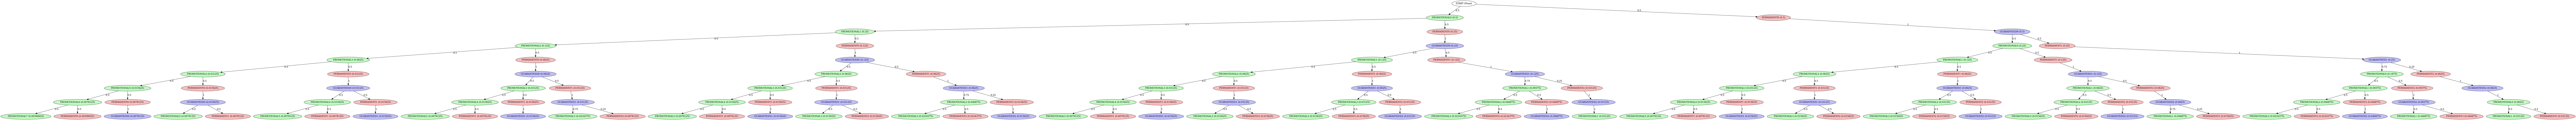

In [36]:
tree = ProbabilityTree(8)
tree.graph.render(node_values=True)

# Función de probabilidad total

Probabilidad total de ganar el 50/50 tirando por cierta cantidad de personajes 5*

In [37]:
max_steps = 31
tree = ProbabilityTree(max_steps)

In [38]:
x_values = np.arange(1, max_steps + 1)
y_values = [tree.calculate_winrate(x) for x in x_values]

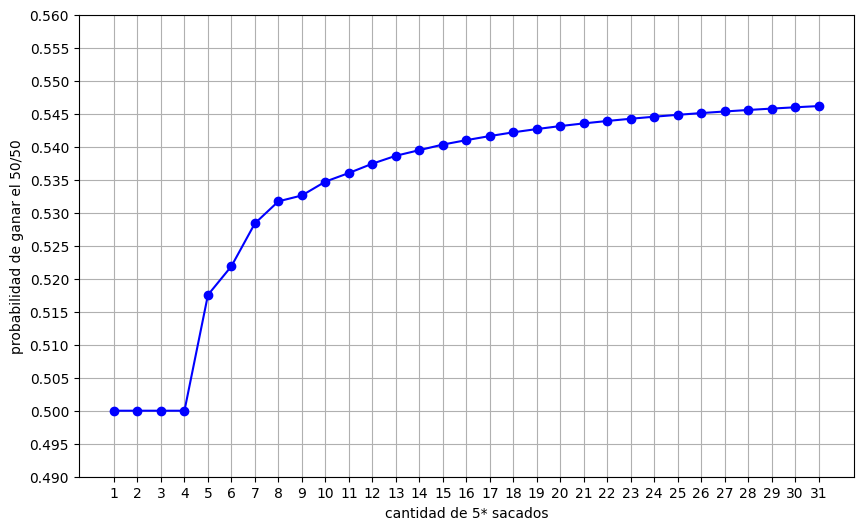

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, marker="o", linestyle="-", color="b")
plt.xlabel("cantidad de 5* sacados")
plt.ylabel("probabilidad de ganar el 50/50")
plt.xticks(np.arange(1, max_steps + 1, 1))
plt.yticks(np.arange(0.49, 0.56, 0.005))
plt.grid(True)